In [414]:
import re
import sys
import pdb
import inspect
from operator import attrgetter,itemgetter
from collections.abc import Mapping
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, default_collate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastprogress import progress_bar,master_bar

## Generate data - simple x^2 function

In [415]:
n_samples = 2000
x_all = np.random.uniform(-2, 2, size=(n_samples, 1)).astype('float32').squeeze()#+np.random.random(n_samples)
y_all = x_all ** 2 +np.random.random(n_samples)*0.5
y_all=y_all/y_all.max()

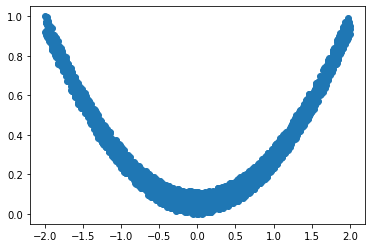

In [416]:
plt.plot(x_all, y_all, "o")

In [417]:
df_all=pd.DataFrame({'x':x_all, 'y':y_all})
df_all.shape

(2000, 2)

In [418]:
df_train=df_all.sample(frac=0.8, random_state=1)
df_test=df_all[~df_all.index.isin(df_train.index)]
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_train.shape, df_test.shape

((1600, 2), (400, 2))

## Callbacks decorator

In [419]:
class with_cbs:
    def __init__(self, nm): 
        self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            #o is learner object
            try:
                # print(f'o in {o}')
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
        return _f

## Learner class

In [420]:
def identity(*args):
    if not args: return
    # pdb.set_trace()
    x,*args = args
    return (x,)+args if args else x

In [421]:
def _store_attr(self, anno, **attrs):
    stored = getattr(self, '__stored_args__', None)
    for n,v in attrs.items():
        if n in anno: 
            v = anno[n](v)
        setattr(self, n, v)
        if stored is not None: 
            stored[n] = v
        
def argnames(f, frame=False):
    "Names of arguments to function or frame `f`"
    code = getattr(f, 'f_code' if frame else '__code__')
    return code.co_varnames[:code.co_argcount+code.co_kwonlyargcount]

def store_attr(names=None, self=None, but='', cast=False, store_args=None, **attrs):
    "Store params named in comma-separated `names` from calling context into attrs in `self`"
    fr = sys._getframe(1)
    args = argnames(fr, True)
    if self: 
        args = ('self', *args)
    else: 
        self = fr.f_locals[args[0]]
    if store_args is None: 
        store_args = not hasattr(self,'__slots__')
    if store_args and not hasattr(self, '__stored_args__'): 
        self.__stored_args__ = {}
    anno = annotations(self) if cast else {}
    if names and isinstance(names,str): 
        names = re.split(', *', names)
    ns = names if names is not None else getattr(self, '__slots__', args[1:])
    added = {n:fr.f_locals[n] for n in ns}
    attrs = {**attrs, **added}
    if isinstance(but,str): 
        but = re.split(', *', but)
    attrs = {k:v for k,v in attrs.items() if k not in but}
    return _store_attr(self, anno, **attrs)

In [422]:
def save_attrs():
    #my version, took only parts needed for current case
    frame=True
    names=None
    but=''
    #pdb.set_trace()
    fr = sys._getframe(1)
    code = getattr(fr, 'f_code')
    args= code.co_varnames[:code.co_argcount+code.co_kwonlyargcount]
    self=fr.f_locals[args[0]]
    store_args = not hasattr(self,'__slots__')
    if store_args and not hasattr(self, '__stored_args__'): 
            self.__stored_args__ = {}
    anno =  {}
    ns=getattr(self, '__slots__', args[1:])
    added = {n:fr.f_locals[n] for n in ns}
    attrs = {**added}
    if isinstance(but,str): 
        but = re.split(', *', but)
    attrs = {k:v for k,v in attrs.items() if k not in but}

    stored = getattr(self, '__stored_args__', None)
    for n,v in attrs.items():
        if n in anno: 
            v = anno[n](v)
        setattr(self, n, v)
        if stored is not None: 
            stored[n] = v
            
#alternative inside class:
# frame = inspect.currentframe()
# args, _, _, values = inspect.getargvalues(frame)
#later filter args you want to store as object attribute

In [423]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=torch.optim.SGD):
        # store_attr()
        save_attrs()
        for cb in cbs: 
            cb.learn = self

    @with_cbs('batch')
    def one_batch(self):
        self.predict()
        self.get_loss()
        if self.model.training:
            self.backward()
            self.step()
            self.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        self._one_epoch()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): 
            self.one_batch()
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self._fit()

    @with_cbs('fit')
    def _fit(self):
        for self.epoch in self.epochs:
            self.one_epoch(True)
            self.one_epoch(False)
        
    def __getattr__(self, name):
        #these are methods that are defined in training CB and turned into learner methods
        if name in ('predict','get_loss','backward','step','zero_grad'): 
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm):
        #loop through all the cbs and run method_nm in them
        for cb in sorted(self.cbs, key=attrgetter('order')): 
            getattr(cb, method_nm, identity)()

In [424]:
identity()

## Callbacks classes

In [504]:
class Callback(): order = 0

In [505]:
class TrainCB(Callback):
    def predict(self): 
        # pdb.set_trace()
        self.learn.preds = self.learn.model(self.learn.batch[0].unsqueeze(1))
    def get_loss(self): 
        self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self): 
        self.learn.loss.backward()
    def step(self): 
        self.learn.opt.step()
    def zero_grad(self): 
        self.learn.opt.zero_grad()

In [506]:
def to_cuda(x):
    if isinstance(x, Mapping):
        return {k:v.cuda() for k,v in x.items()}
    return type(x)(o.cuda() for o in x)

class CudaCB(Callback):
    def before_fit(self): 
        self.learn.model.cuda()
    def before_batch(self): 
        self.learn.batch = to_cuda(self.learn.batch)

In [507]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = torch.tensor(self.ns)
        return (torch.tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

class MSE(Metric):
    def calc(self, inps, targs):
        return (inps - targs).pow(2).mean()

In [508]:
class MetricsCB(Callback):
    def __init__(self, metric=None):
        self.loss_m = Metric()
        self.all = [self.loss_m]
        if metric:
            self.metric = metric
            self.all.append(metric)

    def log(self, *s): 
        print(self.learn.epoch, self.learn.model.training, *s)
    def before_fit(self): 
        self.learn.metrics = self

    def before_epoch(self): 
        [o.reset() for o in self.all]
    def after_epoch(self): 
        self.log(*[f'{o.value:.3f}' for o in self.all])

    def after_batch(self):
        if hasattr(self, 'metric'):
            self.metric.add(self.learn.preds.argmax(dim=1), self.learn.batch[1])
        self.loss_m.add(self.learn.loss, n=len(self.learn.batch[0]))

In [509]:
class ProgressCB(Callback):
    order=MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn, 'metrics'): 
            self.learn.metrics.log = self._log
        self.losses = []
    def _log(self, *s): self.mbar.write(' :: '.join(s))
    def before_epoch(self): 
        self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    def after_batch(self):
        self.learn.dl.comment = f'{self.learn.loss:.3f}'
        if self.plot and hasattr(self.learn, 'metrics') and self.learn.model.training:
            self.losses.append(self.learn.metrics.loss_m.last.item())
            self.mbar.update_graph([[list(range(len(self.losses))), self.losses]])

In [523]:
class LrScheduler(Callback):
    order=TrainCB.order+1
    
    def __init__(self, step_size=2, gamma=0.1):
        self.step_size=step_size
        self.gamma=gamma
        
    def before_fit(self):
        self.learn.scheduler=torch.optim.lr_scheduler.StepLR(self.learn.opt, step_size=self.step_size, gamma=self.gamma)
        self.learn.lrs=[]
        
    def before_batch(self):
        self.learn.lrs.append(self.learn.opt.param_groups[0]["lr"])
        
    def after_batch(self):
        self.learn.scheduler.step()
        

## Dataloader

In [524]:
class SimpleDataset(Dataset):
    def __init__(self, x, y): 
        self.x=torch.tensor(x, dtype=torch.float32)
        self.y=torch.tensor(y, dtype=torch.float32)
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

In [525]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dds, batch_size=128, as_tuple=True):
        return cls(*[DataLoader(ds, batch_size) for ds in dds])

In [539]:
ds_train=SimpleDataset(df_train.x, df_train.y)
ds_test=SimpleDataset(df_test.x, df_test.y)

dls=DataLoaders.from_dd((ds_train, ds_test))

In [540]:
# dt = dls.valid
# xb,yb = next(iter(dt))
# xb.shape,yb[:10]

## Model

In [577]:
n_hidden=50
model = nn.Sequential(nn.Linear(1, n_hidden), 
                          nn.ReLU(), 
                          nn.Linear(n_hidden, 1))

## Init cbs and learner

In [589]:
cbs = [TrainCB(), LrScheduler(step_size=20, gamma=0.2), CudaCB(), MetricsCB(MSE()), ProgressCB(plot=True)]
# cbs = [TrainCB(), CudaCB(), MetricsCB(MSE())]

In [590]:
# learn = Learner(model, dls, F.mse_loss, lr=0.01, cbs=cbs, opt_func=partial(torch.optim.SGD, momentum=0.8))
learn = Learner(model, dls, F.mse_loss, lr=0.01, cbs=cbs, opt_func=torch.optim.SGD)

## Fit

/tmp/ipykernel_309/3698955683.py:6: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])


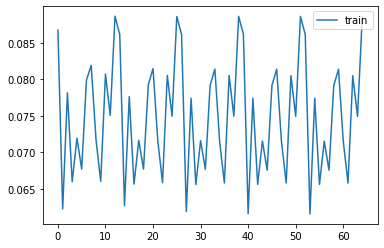

/tmp/ipykernel_309/3698955683.py:6: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
/tmp/ipykernel_309/3698955683.py:6: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])


In [593]:
learn.fit(5)

In [594]:
# learn.metrics.all[0].vals

In [595]:
# learn.metrics.all[1].vals

## Predict

In [596]:
y_reals=[]
y_preds=[]
inps=[]

for batch in dls.valid:
    y_pred_=model(batch[0].to('cuda').unsqueeze(1))
    y_real_=batch[1]
    y_reals.extend(y_real_.detach().numpy())
    y_preds.extend(y_pred_.squeeze(1).cpu().detach().numpy())
    inps.extend(batch[0].detach().numpy())

Text(0, 0.5, 'predicted')

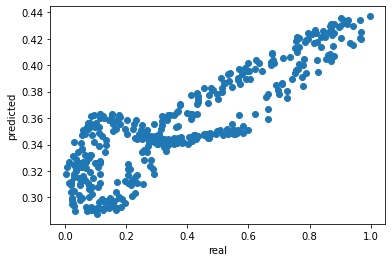

In [597]:
plt.scatter(y_reals, y_preds)
plt.xlabel('real')
plt.ylabel('predicted')

Text(0, 0.5, 'y actual')

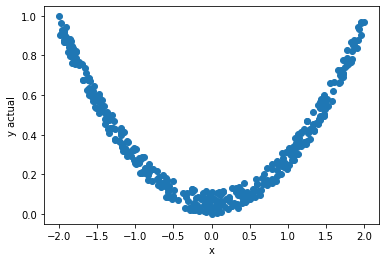

In [598]:
plt.scatter(inps, y_reals)
plt.xlabel('x')
plt.ylabel('y actual')

Text(0, 0.5, 'y predicted')

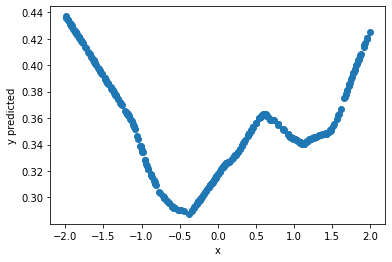

In [599]:
plt.scatter(inps, y_preds)
plt.xlabel('x')
plt.ylabel('y predicted')